In [32]:
import os
import random
from datetime import datetime, timedelta

import boto3
import numpy
import rasterio
import rioxarray
import xarray as xr
from matplotlib import pyplot as plt
import pystac
import pystac_client
import torch
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning import LightningModule, Trainer
import torchvision.transforms as T
from torchvision.transforms import v2

In [2]:
def list_objects_recursive(client, bucket_name, prefix=''):
    """
    List all objects (file keys) in an S3 bucket recursively under a specified prefix.

    Args:
    - client (boto3.client): An initialized Boto3 S3 client.
    - bucket_name (str): The name of the S3 bucket.
    - prefix (str): The prefix (directory path) within the bucket to search for objects (optional).

    Returns:
    - list: A list of file keys (object keys) found under the specified prefix.
    """
    paginator = client.get_paginator('list_objects_v2')

    page_iterator = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

    file_keys = []
    for page in page_iterator:
        if 'Contents' in page:
            file_keys.extend([obj['Key'] for obj in page['Contents']])

    return file_keys

In [3]:
image_array_values = []
label_array_values = []
flood_events = []
positions = []

def get_image_granules(bucket_name, prefix):
    """
    Get granules of N-dim datacube and label images from an S3 bucket.

    Args:
    - bucket_name (str): The name of the S3 bucket.
    - prefix (str): The prefix (directory path) in the S3 bucket.

    Returns:
    - tuple: None.
    """
    # Initialize Boto3 S3 client
    s3 = boto3.client('s3')

    # List objects in the specified prefix (directory) in the bucket
    files_in_s3 = list_objects_recursive(s3, bucket_name, prefix)

    # Filter S2 and S1 images
    S1_labels = [i for i in files_in_s3 if 'LabelWater.tif' in i]
    datacube_images = [f"{i[:-15]}.tif" for i in S1_labels]
    
    for i in datacube_images[0:100]:
        position = '_'.join(i.split('/')[-1].split('_')[-3:-1])
        positions.append(position)
        flood_event = i.split('/')[-2]
        flood_events.append(flood_event)         
        # Load the image file from S3 directly into memory using rasterio
        obj = s3.get_object(Bucket=bucket_name, Key=i)
        with rasterio.io.MemoryFile(obj['Body'].read()) as memfile:
            with memfile.open() as dataset:
                data_array = rioxarray.open_rasterio(dataset)
                #print(data_array.values)
                pair = [i, data_array.values]
                image_array_values.append(pair)
    for i in S1_labels[0:100]:
        # Load the image file from S3 directly into memory using rasterio
        obj = s3.get_object(Bucket=bucket_name, Key=i)
        with rasterio.io.MemoryFile(obj['Body'].read()) as memfile:
            with memfile.open() as dataset:
                data_array = rioxarray.open_rasterio(dataset)
                #print(data_array.values)
                pair = [i, data_array.values]
                label_array_values.append(pair)

get_image_granules(bucket_name='clay-benchmark', prefix='c2smsfloods/datacube/chips_512/')

In [4]:
import random
random.seed(9)  # set a seed for reproducibility

# put 1/3 of chips into the validation set
chip_ids_values = range(len(label_array_values))
val_chip_ids_values = random.sample(chip_ids_values, round(len(chip_ids_values) * 0.33))
train_chip_ids_values = [i for i in chip_ids_values if i not in val_chip_ids_values]
train_images_values = []
train_labels_values = []
for i,j,k in zip(image_array_values, label_array_values, range(len(image_array_values))):
    if k in train_chip_ids_values:
        train_images_values.append(i)
        train_labels_values.append(j)
val_images_values = []
val_labels_values = []
for i,j,k in zip(image_array_values, label_array_values, range(len(image_array_values))):
    if k in val_chip_ids_values:
        val_images_values.append(i)
        val_labels_values.append(j)
        
print(len(train_images_values), len(val_images_values), len(train_labels_values), len(val_labels_values))

67 33 67 33


In [5]:
def plot(merged):
    """
    Plot a tile in RGB and vh, and DEM
    """

    # data = merged.coarsen(x=100, y=100, boundary="trim").mean()
    data = merged

    fig, axs = plt.subplots(1, 3, figsize=(30, 30))


    rgb = (
        numpy.array(
            [
                data[2],
                data[1],
                data[0],
            ]
        ).clip(0, 3000)
        / 3000
    )
    axs[0].imshow(rgb.transpose(1, 2, 0))
    axs[0].set_title("Sentinel-2", fontsize=15)
    axs[1].imshow(numpy.log(data[11]))
    axs[1].set_title("Sentinel-1 VH", fontsize=15)
    axs[2].imshow(data[12])
    axs[2].set_title("DEM", fontsize=15)

    plt.show()

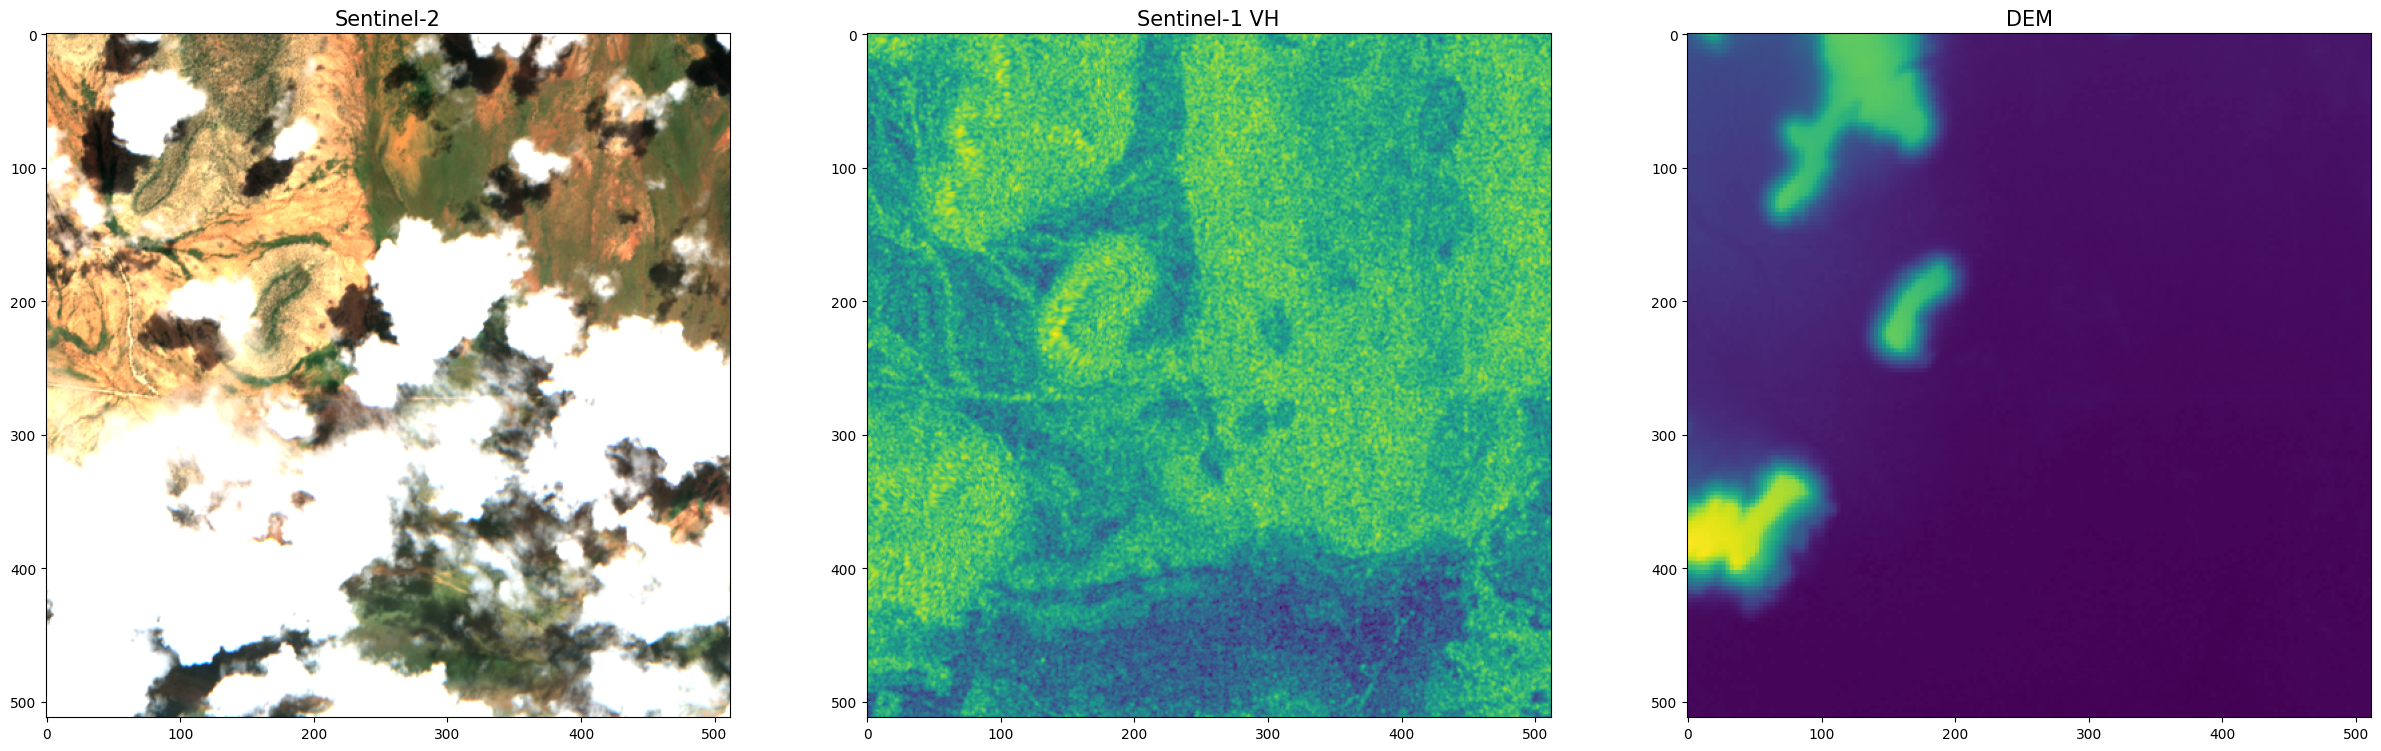

In [6]:
plot(image_array_values[0][1])

In [35]:
class DataModule_Floods(LightningModule):
    MEAN = [
        518.393981,
        670.384338,
        583.347534,
        961.506958,
        1903.755737,
        2138.707519,
        2238.332031,
        2273.117919,
        1413.791137,
        808.279968,
        0.033653,
        0.135196,
        536.390136,
    ]

    STD = [
        876.523559,
        918.090148,
        981.493835,
        1001.560729,
        1256.656372,
        1346.299072,
        1414.495483,
        1392.251342,
        918.297912,
        605.479919,
        0.048188,
        0.380075,
        630.602233,
    ]
    def __init__(self, train_images, val_images, train_labels, val_labels, batch_size=2, num_workers=4):
        super().__init__()
        self.train_images = train_images
        self.val_images = val_images
        self.train_labels = train_labels
        self.val_labels = val_labels
        self.batch_size = batch_size
        self.num_workers = num_workers 
        self.tfm = v2.Compose(
            [
                v2.Normalize(mean=self.MEAN, std=self.STD),
            ]
        )
        
        self.train_dataset = self.get_dataset(self.train_images, self.train_labels, transform=self.tfm)
        self.val_dataset = self.get_dataset(self.val_images, self.val_labels, transform=self.tfm)

    def get_dataset(self, images, labels, transform=None):
        #print(images[0][1].transpose(1,2,0).shape, labels[0][1].transpose(1,2,0).shape)
        features = [torch.tensor(numpy.array(item[1])) for item in images]  # Convert NumPy array to PyTorch tensor
        targets = [torch.tensor(numpy.array(item[1])) for item in labels] 
        print(len(features),len(targets))
        if transform:
            # convert to float16 and normalize
            features = [transform(feature) for feature in features]
        dataset = torch.utils.data.TensorDataset(torch.stack(features), torch.stack(targets))
        return dataset

    def train_dataloader(self):
        # Return the training DataLoader
        #transform = transforms.Compose([transforms.ToTensor()])
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, drop_last=True, num_workers=self.num_workers, shuffle=True)
        return train_loader

    def val_dataloader(self):
        # Return the training DataLoader
        #transform = transforms.Compose([transforms.ToTensor()])
        val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, drop_last=True, num_workers=self.num_workers, shuffle=False)
        return val_loader
        
    
datamodule_floods = DataModule_Floods(train_images_values, val_images_values, train_labels_values, val_labels_values)
datamodule_floods.setup(stage='fit')



67 67
33 33


In [38]:
class UNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(128, 512, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(512, out_channels, kernel_size=3, padding=1),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)
        # Decoder
        x = self.decoder(x1)
        return x

class SegmentationModel(LightningModule):
    def __init__(self, model, datamodule):
        super().__init__()
        self.model = model
        self.datamodule = datamodule

    def forward(self, x):
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        #x = torch.tensor(x, requires_grad=True)
        y = y.to(dtype=torch.float32)
        y = y.squeeze()
        print("Shapes - x:", x.shape, "y:", y.shape)
        y_pred = self.model(x)
        _, prediction = torch.max(y_pred, dim=1)
        print("Prediction shape:", prediction.shape)
        print("Label shape:", y.shape)
        loss = torch.nn.functional.cross_entropy(prediction.to(dtype=torch.float32), y)
        loss = torch.tensor(loss, requires_grad = True)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x = torch.tensor(x, requires_grad=True)
        y = y.to(dtype=torch.float32)
        y = y.squeeze()
        print("Shapes - x:", x.shape, "y:", y.shape)
        y_pred = self.model(x)
        _, prediction = torch.max(y_pred, dim=1)
        print("Prediction shape:", prediction.shape)
        print("Label shape:", y.shape)
        val_loss = torch.nn.functional.cross_entropy(prediction.to(dtype=torch.float32), y)
        val_loss = torch.tensor(val_loss, requires_grad = True)
        self.log('val_loss', val_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

    def train_dataloader(self):
        return self.datamodule.train_dataloader()

    def val_dataloader(self):
        return self.datamodule.val_dataloader()

model = UNet(13, 2) 
segmentation_model = SegmentationModel(model, datamodule_floods)

trainer = Trainer(max_epochs=3)  
trainer.fit(segmentation_model)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | model      | UNet              | 717 K 
1 | datamodule | DataModule_Floods | 0     
-------------------------------------------------
717 K     Trainable params
0         Non-trainable params
717 K     Total params
2.872     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                                                                                                                                                   | 0/2 [00:00<?, ?it/s]Shapes - x: torch.Size([2, 13, 512, 512]) y: torch.Size([2, 512, 512])
Prediction shape: torch.Size([2, 512, 512])
Label shape: torch.Size([2, 512, 512])
Sanity Checking DataLoader 0:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 1/2 [00:05<00:05,  5.37s/it]Shapes - x: torch.Size([2, 13, 512, 512]) y: torch.Size([2, 512, 512])


/var/folders/wz/qvnrzvw92_zfzw3lmwsf1mjh0000gn/T/ipykernel_1878/1883087712.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss = torch.tensor(val_loss, requires_grad = True)


Prediction shape: torch.Size([2, 512, 512])
Label shape: torch.Size([2, 512, 512])
Epoch 0:   0%|                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]Shapes - x: torch.Size([2, 13, 512, 512]) y: torch.Size([2, 512, 512])
Prediction shape: torch.Size([2, 512, 512])
Label shape: torch.Size([2, 512, 512])
Epoch 0:   2%|██▊                                                                                                                                        | 1/49 [00:09<07:59,  9.99s/it, loss=0.34, v_num=3]Shapes - x: torch.Size([2, 13, 512, 512]) y: torch.Size([2, 512, 512])


/var/folders/wz/qvnrzvw92_zfzw3lmwsf1mjh0000gn/T/ipykernel_1878/1883087712.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.tensor(loss, requires_grad = True)


Prediction shape: torch.Size([2, 512, 512])
Label shape: torch.Size([2, 512, 512])
Epoch 0:   4%|█████▋                                                                                                                                      | 2/49 [00:15<05:57,  7.61s/it, loss=274, v_num=3]Shapes - x: torch.Size([2, 13, 512, 512]) y: torch.Size([2, 512, 512])
Prediction shape: torch.Size([2, 512, 512])
Label shape: torch.Size([2, 512, 512])
Epoch 0:   6%|████████▌                                                                                                                                   | 3/49 [00:20<05:12,  6.79s/it, loss=183, v_num=3]Shapes - x: torch.Size([2, 13, 512, 512]) y: torch.Size([2, 512, 512])
Prediction shape: torch.Size([2, 512, 512])
Label shape: torch.Size([2, 512, 512])
Epoch 0:   8%|███████████▍                                                                                                                                | 4/49 [00:25<04:44,  6.31s/it, loss=146, v_num

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]
[0 1]


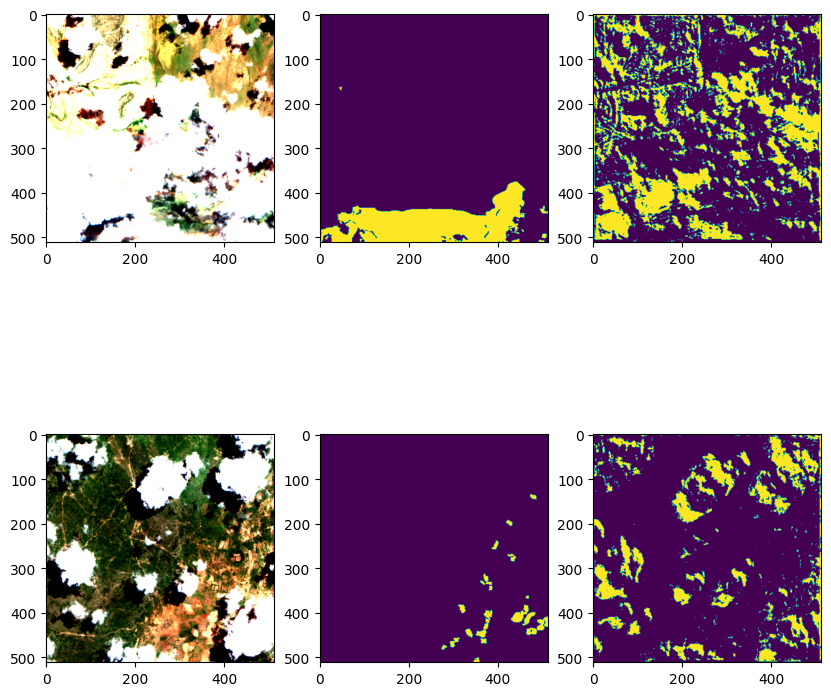

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]
[0 1]


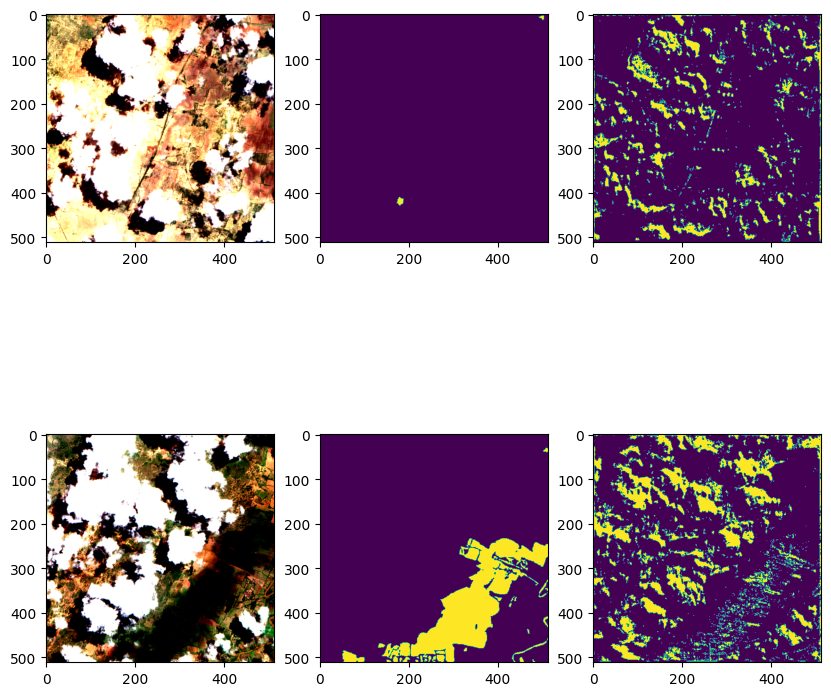

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]
[0]


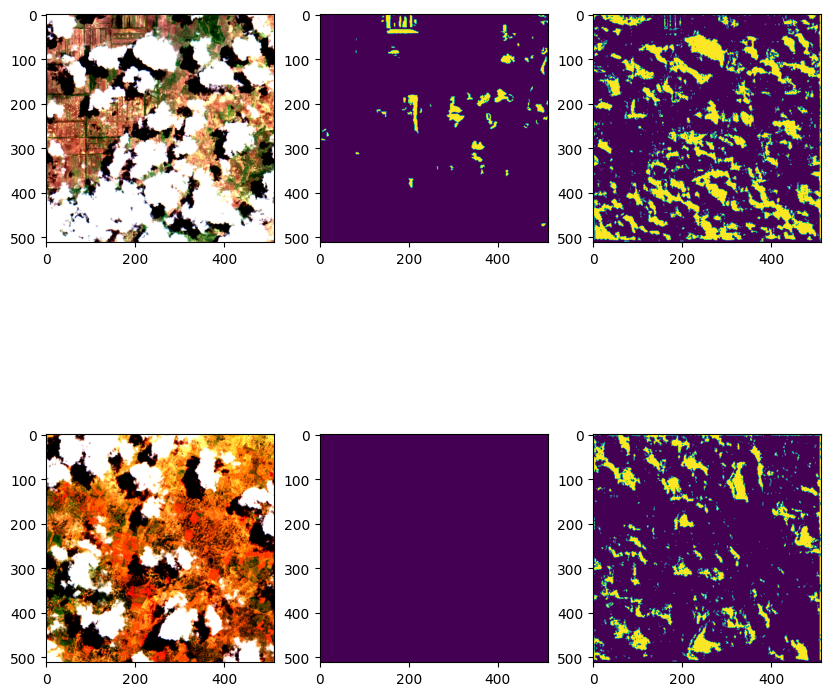

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0]
[0]


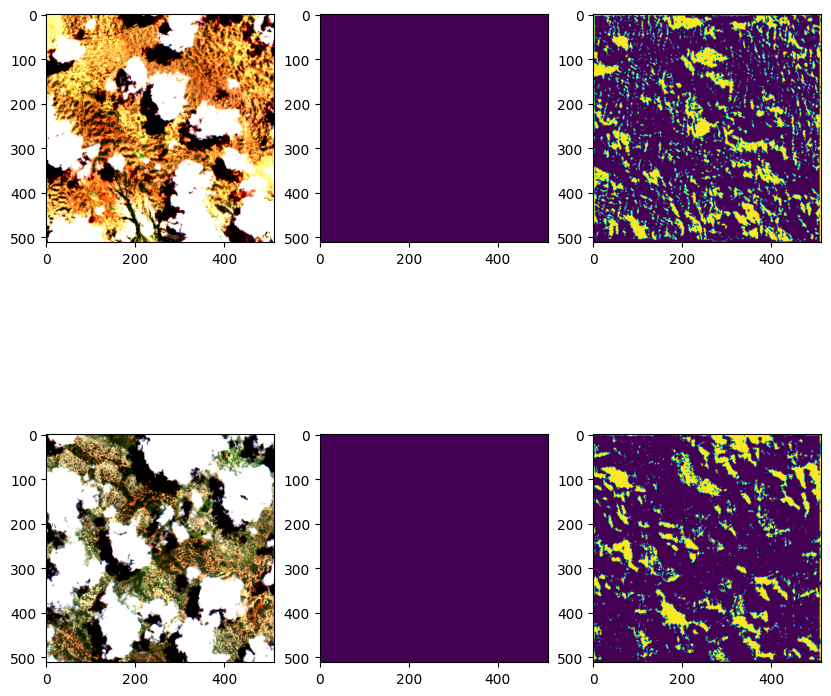

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0]
[0 1]


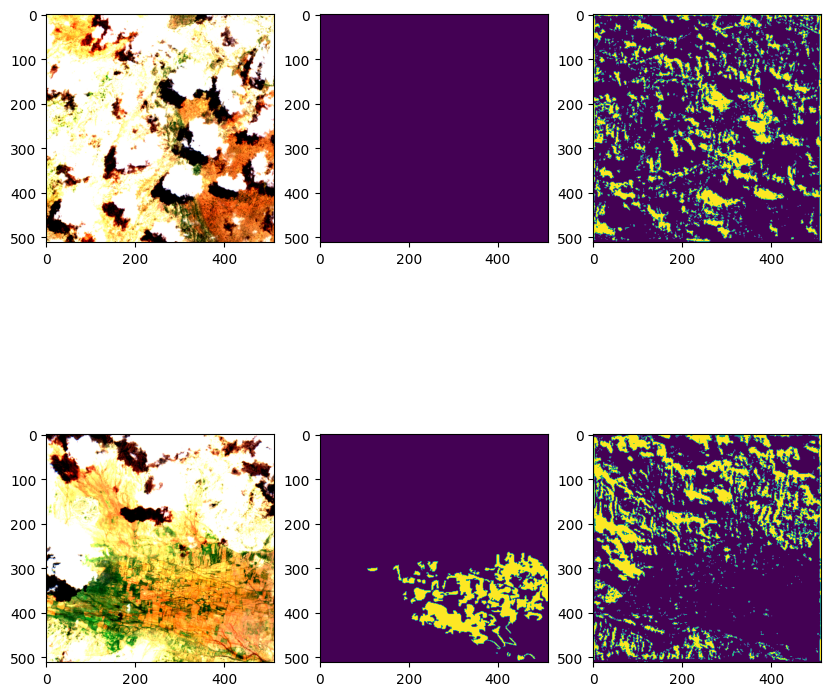

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]
[0 1]


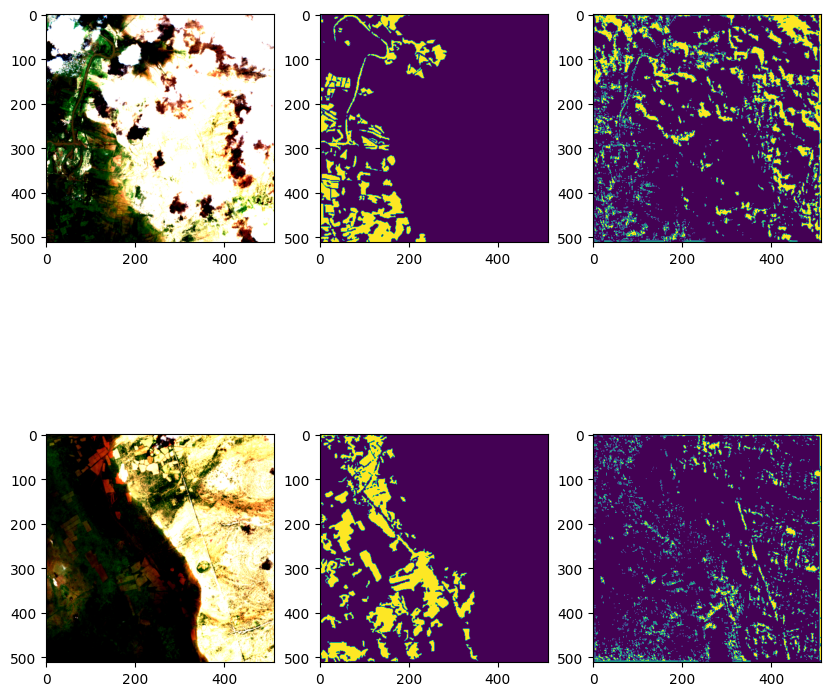

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]
[0 1]


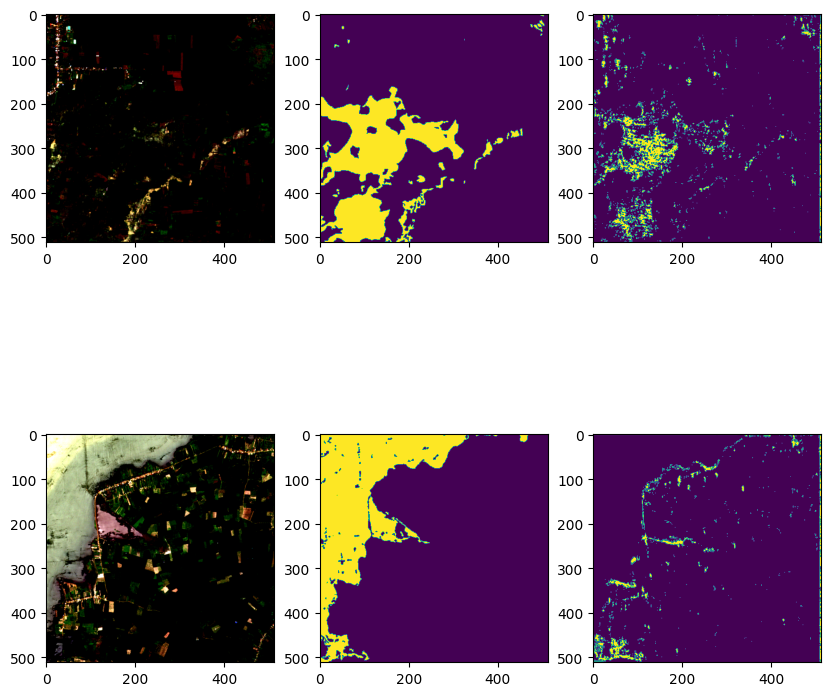

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]
[0 1]


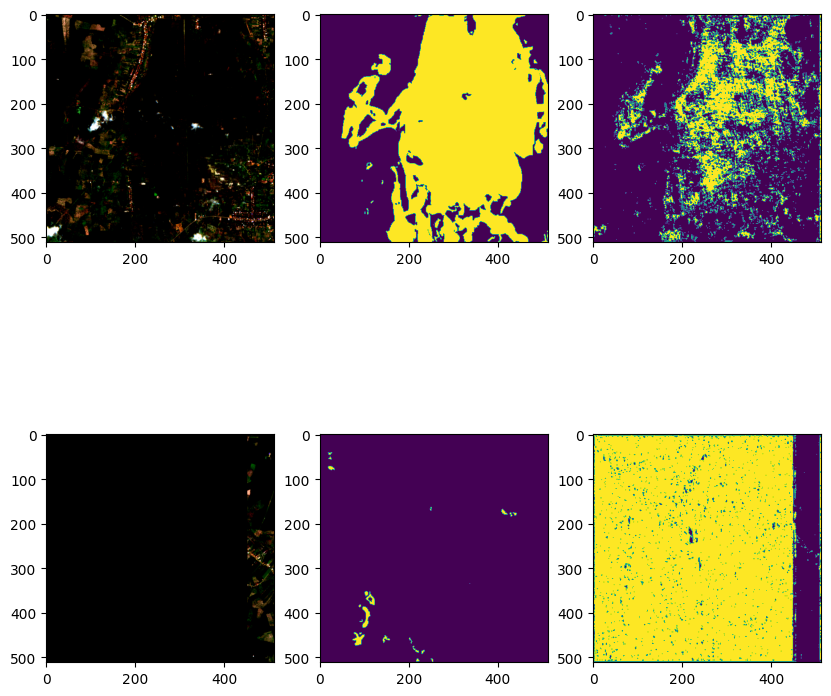

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]
[0]


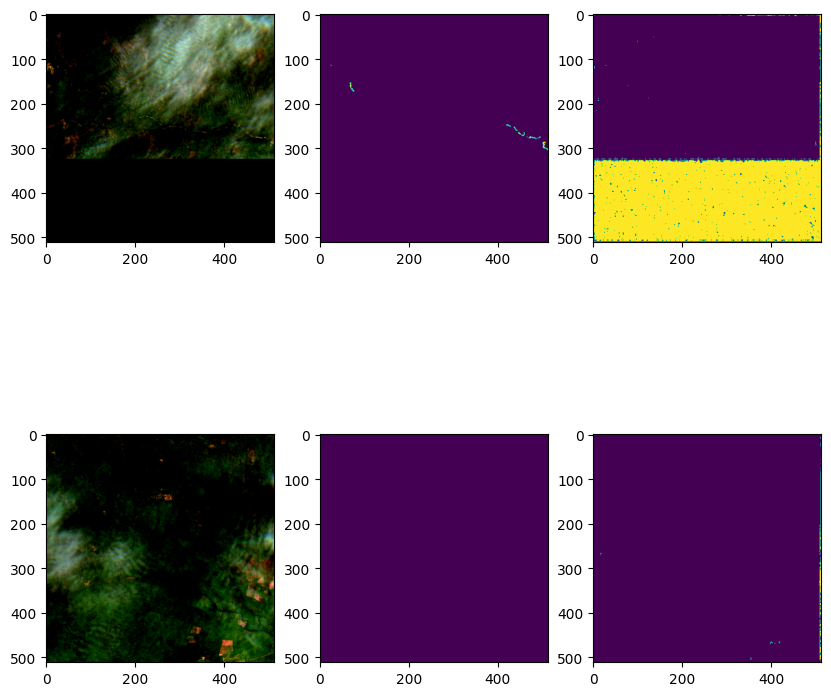

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0]
[0 1]


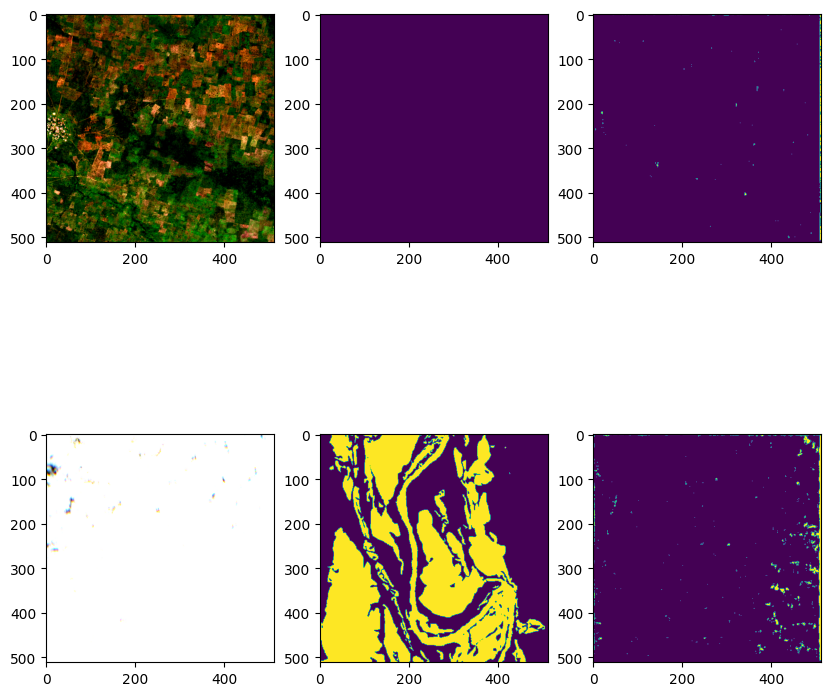

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]
[0 1]


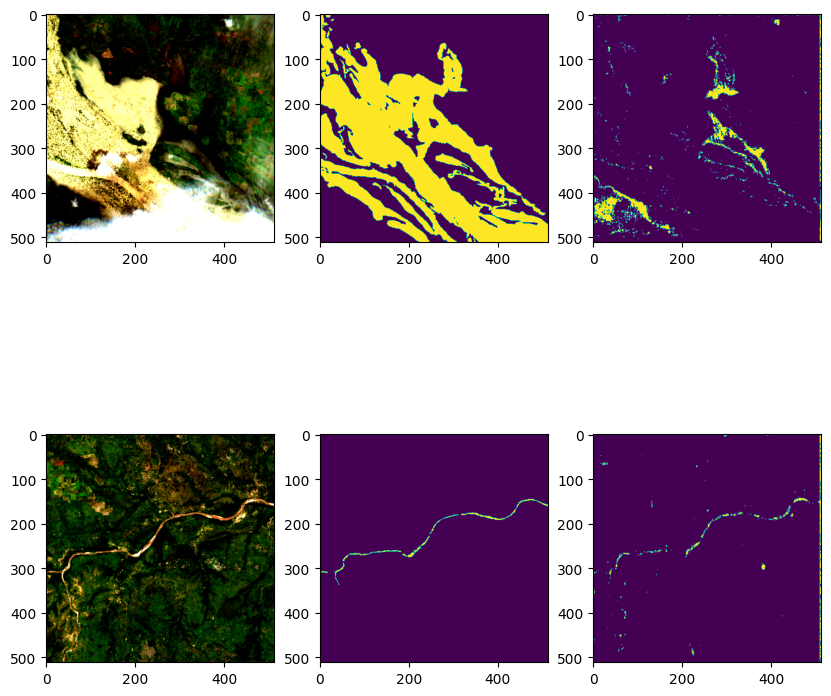

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0]
[0 1]


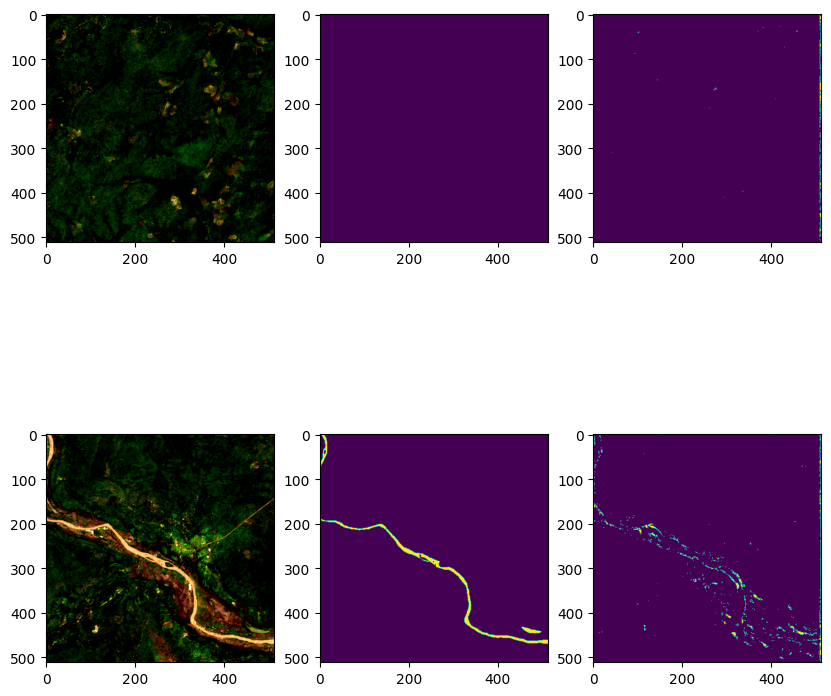

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]
[0 1]


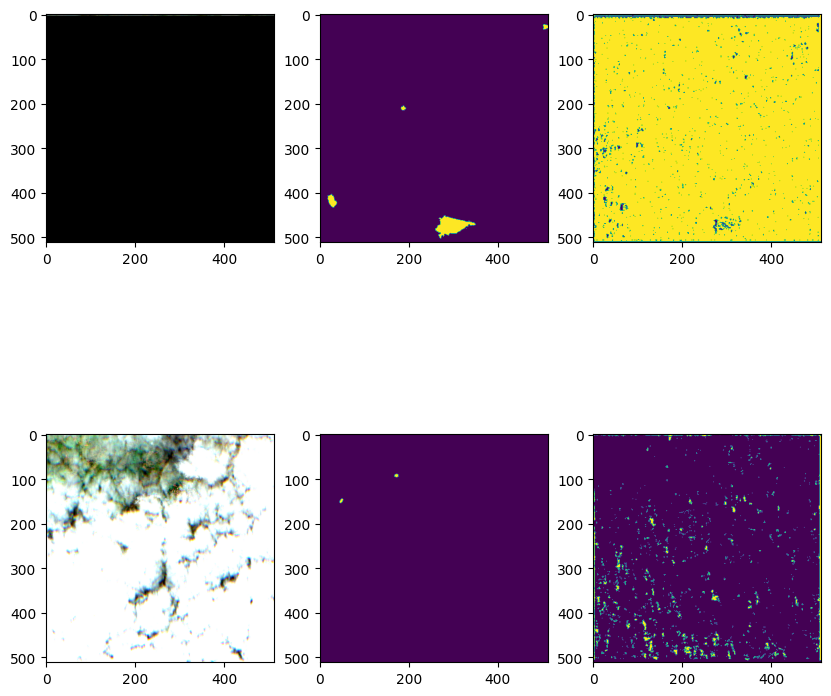

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]
[0 1]


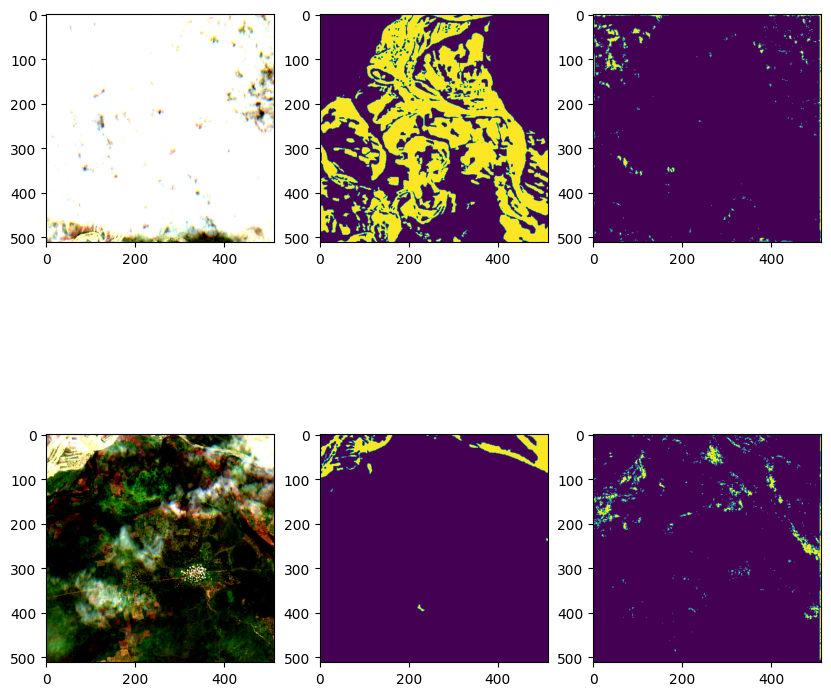

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]
[0]


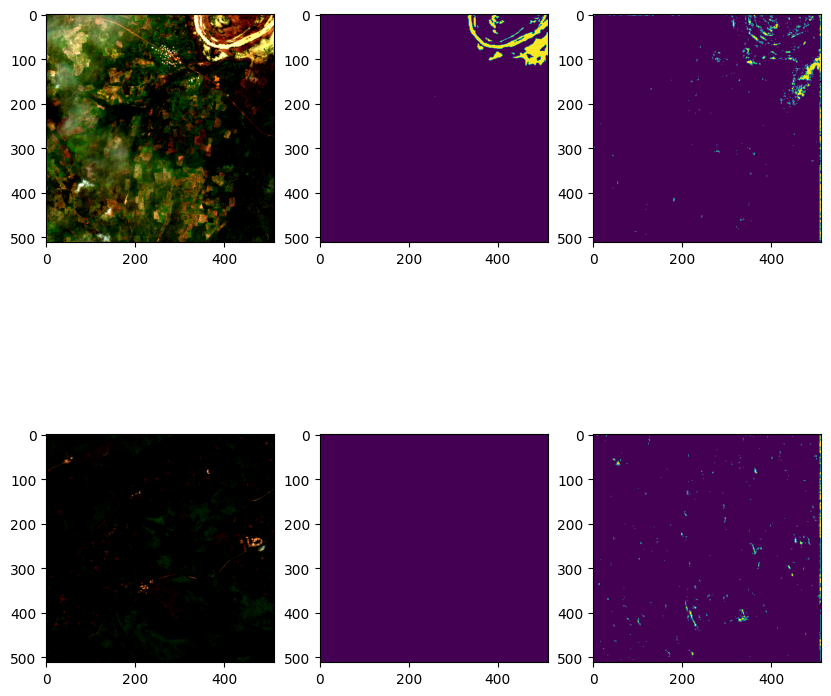

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]
[0]


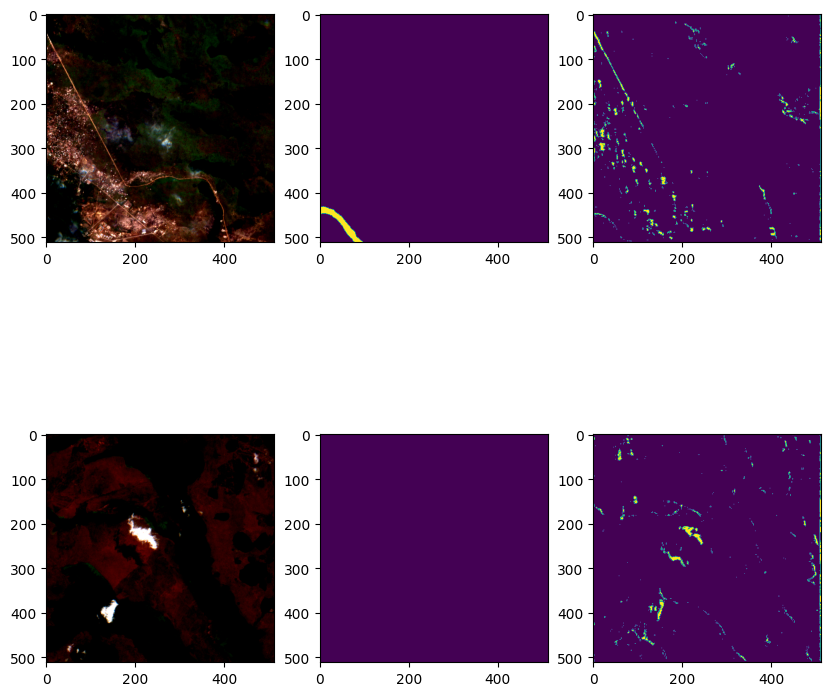

In [39]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

def plot_predictions(model, dataloader):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            x_val, y_val = batch
            y_pred = model(x_val)
            _, prediction = torch.max(y_pred, dim=1)

            # Convert tensors to NumPy arrays for plotting
            x_val_np = x_val.cpu().numpy()
            y_val_np = y_val.cpu().numpy()
            prediction_np = prediction.cpu().numpy()

            # Plot images and masks
            num_samples = min(4, len(x_val))  # Number of samples to visualize
            fig, axes = plt.subplots(num_samples, 3, figsize=(10, 10))

            for i in range(num_samples):
                print(numpy.unique(y_val_np[i]))
                #print(numpy.stack((x_val_np[i][2,:,:], x_val_np[i][1,:,:], x_val_np[i][0,:,:])))
                #axes[i, 0].imshow(numpy.transpose(numpy.stack((x_val_np[i][2,:,:], x_val_np[i][1,:,:], x_val_np[i][0,:,:])), (1, 2, 0)).clip(0, 3000) / 3000)#x_val_np[i], (1, 2, 0)))  # Plot input images
                axes[i, 0].imshow(numpy.transpose(numpy.stack((x_val_np[i][2,:,:], x_val_np[i][1,:,:], x_val_np[i][0,:,:])), (1, 2, 0)))#x_val_np[i], (1, 2, 0)))  # Plot input images
                axes[i, 1].imshow(numpy.transpose(y_val_np[i], (1, 2, 0)))  # Plot ground truths
                axes[i, 2].imshow(prediction_np[i])  # Plot model predictions

            plt.show()

val_dataloader = datamodule_floods.val_dataloader()

# Load the trained model
#loaded_model = UNet(13, 2)  # Initialize the model architecture
#loaded_model.load_state_dict(torch.load('path_to_your_trained_model.pth'))  # Load trained weights

# Run predictions and plot results
plot_predictions(model, val_dataloader)
